In [1]:
import torch
import numpy as np

torch.manual_seed(0)

In [167]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns u(x,y), computes d^2u/dx^2 using torch.autograd."""
    grad= torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(outputs),
        create_graph = True,
        retain_graph = True,
        )[0]

    grad_y = grad[:, 1]  # Select the column corresponding to the derivative with respect to y
    second_derivative_y = torch.autograd.grad(
        grad_y,
        inputs,
        torch.ones_like(grad_y),  # This tensor is required as grad_y is not scalar
        create_graph=True,
        retain_graph=True
        )[0]


    grad_x = grad[:, 0]  # Select the column corresponding to the derivative with respect to y
    second_derivative_x = torch.autograd.grad(
        grad_x,
        inputs,
        torch.ones_like(grad_y),  # This tensor is required as grad_y is not scalar
        create_graph=True,
        retain_graph=True
        )[0]
    sec2=torch.add(second_derivative_x[:,0],second_derivative_y[:,1])

    return sec2



In [234]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = torch.zeros_like(model_output[:,0])

    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_left = inputs.detach().clone()
    boundary_left[:,0] = 0
    boundary_bottom = inputs.detach().clone()
    boundary_bottom[:,1] = 0
    boundary_right = inputs.detach().clone()
    boundary_right[:,0] = 1
    boundary_top = inputs.detach().clone()
    boundary_top[:,1] = 1

    boundary1_model = model(boundary_left)
    boundary1_exact = torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary1_loss = criterion(boundary1_model, boundary1_exact)
    boundary2_model = model(boundary_bottom)
    boundary2_exact = torch.zeros_like(model_output)
    boundary2_loss = criterion(boundary2_model, boundary2_exact)
    boundary3_model = model(boundary_right)
    boundary3_exact = np.exp(-torch.pi)*torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary3_loss = criterion(boundary3_model, boundary3_exact)
    boundary4_model = model(boundary_top)
    boundary4_exact = torch.zeros_like(model_output)
    boundary4_loss = criterion(boundary4_model, boundary4_exact)

    return 0.01*ode_loss + boundary1_loss + boundary2_loss + boundary3_loss + boundary4_loss

In [240]:
from qadence import feature_map, hea, chain, add, kron, identity_initialized_ansatz
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 4
depth = 4

# Feature map
fm_x = feature_map(
    n_qubits = 2,
    support=[0,1],
    param = "x",
    fm_type = BasisSet.FOURIER,
    reupload_scaling = ReuploadScaling.TOWER,
)

fm_y = feature_map(
    n_qubits = 2,
    param = "y",
    support=[2,3],
    fm_type = BasisSet.FOURIER,
    reupload_scaling = ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits, depth)

# Observable
observable = add(Z(i) for i in range(n_qubits))

circuit = QuantumCircuit(n_qubits, chain(fm_x, fm_y, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x", "y"])

In [241]:
n_epochs = 1000

xmin = 0
xmax = 0.999
x_points = 10
ymin = 0
ymax = 0.999
y_points = 10

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    xy_train = torch.stack((xmin + (xmax-xmin)*torch.rand(x_points, y_points, requires_grad = True),
           ymin + (ymax-ymin)*torch.rand(x_points, y_points, requires_grad = True))).swapdims(0, 2).flatten(end_dim=1)

    loss = loss_fn(inputs = xy_train, model = model)
    print(loss)
    loss.backward()
    optimizer.step()

tensor(0.7328, grad_fn=<AddBackward0>)
tensor(0.6730, grad_fn=<AddBackward0>)
tensor(0.3830, grad_fn=<AddBackward0>)
tensor(0.2693, grad_fn=<AddBackward0>)
tensor(0.2739, grad_fn=<AddBackward0>)
tensor(0.3088, grad_fn=<AddBackward0>)
tensor(0.1843, grad_fn=<AddBackward0>)
tensor(0.1511, grad_fn=<AddBackward0>)
tensor(0.1022, grad_fn=<AddBackward0>)
tensor(0.1336, grad_fn=<AddBackward0>)
tensor(0.1277, grad_fn=<AddBackward0>)
tensor(0.0835, grad_fn=<AddBackward0>)
tensor(0.0949, grad_fn=<AddBackward0>)
tensor(0.1012, grad_fn=<AddBackward0>)
tensor(0.1206, grad_fn=<AddBackward0>)
tensor(0.0986, grad_fn=<AddBackward0>)
tensor(0.0806, grad_fn=<AddBackward0>)
tensor(0.1259, grad_fn=<AddBackward0>)
tensor(0.0990, grad_fn=<AddBackward0>)
tensor(0.0735, grad_fn=<AddBackward0>)
tensor(0.0799, grad_fn=<AddBackward0>)
tensor(0.0948, grad_fn=<AddBackward0>)
tensor(0.0821, grad_fn=<AddBackward0>)
tensor(0.0595, grad_fn=<AddBackward0>)
tensor(0.0720, grad_fn=<AddBackward0>)
tensor(0.0720, grad_fn=<A

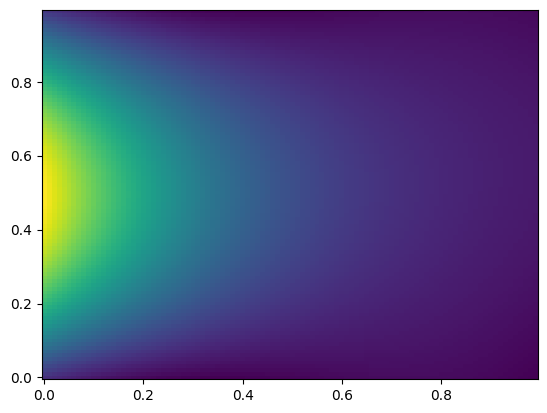

In [242]:
import matplotlib.pyplot as plt
import numpy as np

# result_exact = f_exact(x_test).flatten()
x = torch.arange(xmin, xmax, 0.01)
xy_test = torch.cartesian_prod(x, x)

X, Y = torch.meshgrid(x, x)

result_model = model(xy_test).detach().unflatten(0,(x.shape[0], x.shape[0]))

# plt.plot(x_test, result_exact, label = "Exact solution")
plt.pcolormesh(X.detach().numpy(), Y.detach().numpy(), result_model.squeeze(2).detach().numpy(), label = " Trained model")